# 📊 Forex Signal Model - Phase 2: Model Development

This notebook trains and evaluates three baseline models:
1. **Technical Rules System** - Rule-based signals
2. **XGBoost Classifier** - ML-based pattern recognition
3. **Ensemble** - Combined approach

## Setup

In [1]:
import sys
import warnings
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(f"Project root: {project_root}")

Project root: C:\Users\Abdulfatai Sanusi\Desktop\FOREX MODEL\forex_signal_model


## 1. Load Data

In [2]:
# Load features
features_path = project_root / 'data' / 'processed' / 'features.parquet'
df = pd.read_parquet(features_path)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Columns: {len(df.columns)}")

Data shape: (1509, 213)
Date range: 2020-01-03 00:00:00 to 2026-01-02 00:00:00
Columns: 213


In [3]:
# Check target balance
target_cols = [c for c in df.columns if 'Target_Direction' in c]
print("\nTarget Distribution:")
for col in target_cols:
    counts = df[col].value_counts(normalize=True)
    print(f"  {col}: {counts.to_dict()}")


Target Distribution:
  GBPUSD_Target_Direction: {1: 0.5049701789264414, 0: 0.49502982107355864}
  EURUSD_Target_Direction: {0: 0.508283631544069, 1: 0.4917163684559311}
  GC=F_Target_Direction: {1: 0.5546719681908548, 0: 0.44532803180914515}


In [4]:
# Train/Test split (time-based)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"Train: {len(train_df)} samples ({train_df.index.min()} to {train_df.index.max()})")
print(f"Test: {len(test_df)} samples ({test_df.index.min()} to {test_df.index.max()})")

Train: 1207 samples (2020-01-03 00:00:00 to 2024-10-18 00:00:00)
Test: 302 samples (2024-10-21 00:00:00 to 2026-01-02 00:00:00)


## 2. Technical Rules System

In [5]:
from src.models.technical_rules import TechnicalRulesSystem

# Initialize
tech_system = TechnicalRulesSystem(str(project_root / 'config' / 'config.yaml'))

# Generate signals
tech_signals = tech_system.generate_all_signals(df)
tech_summary = tech_system.get_signal_summary(tech_signals)

print("\nTechnical Rules Summary:")
for k, v in tech_summary.items():
    print(f"  {k}: {v}")


Technical Rules Summary:
  total_signals: 4527
  buy_signals: 0
  sell_signals: 0
  hold_signals: 4527
  avg_confidence: 21.348101865000466
  high_confidence_signals: 0
  GBPUSD=X_buy: 0
  GBPUSD=X_sell: 0
  EURUSD=X_buy: 0
  EURUSD=X_sell: 0
  GC=F_buy: 0
  GC=F_sell: 0


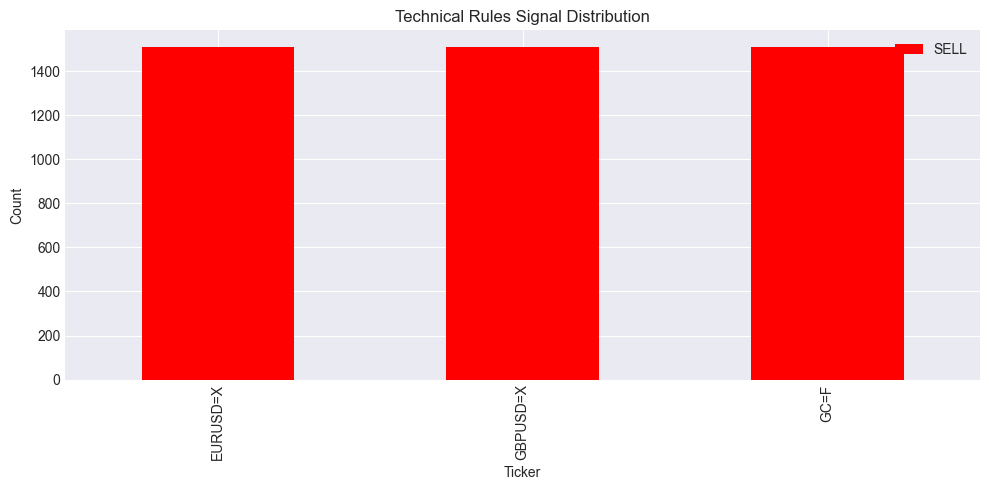

In [6]:
# Signal distribution by ticker
fig, ax = plt.subplots(figsize=(10, 5))
tech_signals.groupby(['Ticker', 'Signal']).size().unstack(fill_value=0).plot(
    kind='bar', ax=ax, color=['red', 'gray', 'green'])
ax.set_title('Technical Rules Signal Distribution')
ax.set_xlabel('Ticker')
ax.set_ylabel('Count')
ax.legend(['SELL', 'HOLD', 'BUY'])
plt.tight_layout()
plt.show()

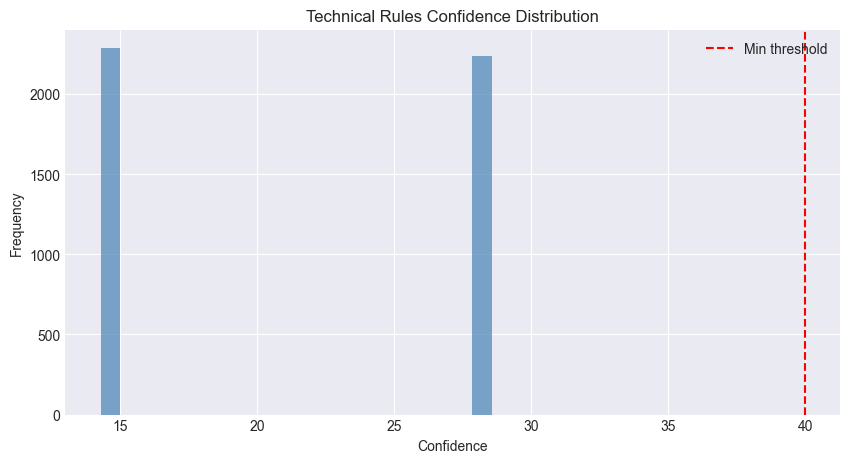

In [7]:
# Confidence distribution
fig, ax = plt.subplots(figsize=(10, 5))
tech_signals['Confidence'].hist(bins=20, ax=ax, color='steelblue', alpha=0.7)
ax.axvline(x=40, color='red', linestyle='--', label='Min threshold')
ax.set_title('Technical Rules Confidence Distribution')
ax.set_xlabel('Confidence')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

## 3. XGBoost Model

In [8]:
from src.models.ml_models import XGBoostTradingModel

# Initialize and train
xgb_model = XGBoostTradingModel(str(project_root / 'config' / 'config.yaml'))

# Train for all tickers (no hyperparameter tuning for speed)
xgb_metrics = xgb_model.train_all(df, tune_hyperparams=False)

print("\nXGBoost Training Results:")
for ticker, m in xgb_metrics.items():
    if 'error' not in m:
        print(f"  {ticker}: Val Acc={m['val_accuracy']:.3f}, Test Acc={m['test_accuracy']:.3f}, AUC={m.get('test_auc', 0):.3f}")


XGBoost Training Results:
  GBPUSD=X: Val Acc=0.530, Test Acc=0.513, AUC=0.496
  EURUSD=X: Val Acc=0.503, Test Acc=0.500, AUC=0.478
  GC=F: Val Acc=0.503, Test Acc=0.510, AUC=0.472


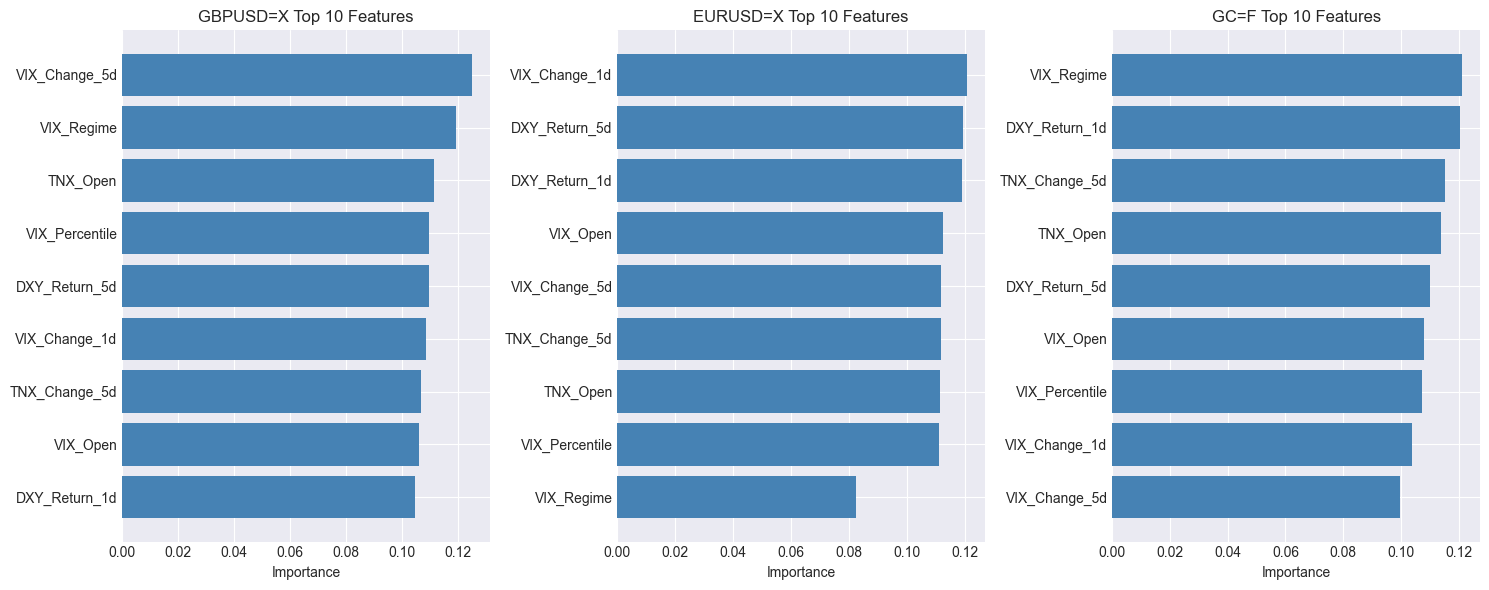

In [9]:
# Feature importance for each ticker
fig, axes = plt.subplots(1, len(xgb_model.feature_importance), figsize=(15, 6))
if len(xgb_model.feature_importance) == 1:
    axes = [axes]

for ax, (ticker, importance) in zip(axes, xgb_model.feature_importance.items()):
    top10 = importance.head(10)
    ax.barh(range(len(top10)), top10['importance'].values, color='steelblue')
    ax.set_yticks(range(len(top10)))
    ax.set_yticklabels(top10['feature'].values)
    ax.invert_yaxis()
    ax.set_title(f'{ticker} Top 10 Features')
    ax.set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [10]:
# Generate predictions
xgb_signals = xgb_model.predict_all(df)
print(f"\nXGBoost signals: {len(xgb_signals)} total")
print(xgb_signals.groupby(['Ticker', 'Signal']).size().unstack(fill_value=0))


XGBoost signals: 4527 total
Signal     -1    1
Ticker            
EURUSD=X  698  811
GBPUSD=X  785  724
GC=F      607  902


## 4. Ensemble Model

In [11]:
from src.models.ensemble import EnsembleModel

# Initialize and train
ensemble = EnsembleModel(str(project_root / 'config' / 'config.yaml'))
ensemble_results = ensemble.train(df, tune_hyperparams=False)

# Generate predictions
ensemble_signals = ensemble.predict(df)
ensemble_analysis = ensemble.get_signal_analysis(ensemble_signals)

print("\nEnsemble Analysis:")
for k, v in ensemble_analysis.items():
    print(f"  {k}: {v}")


Ensemble Analysis:
  total_signals: 4527
  buy_count: 1084
  sell_count: 839
  hold_count: 2604
  agreement_rate: 0.0
  avg_confidence: 30.136774965488925
  high_confidence_signals: 0
  GBPUSD=X_buy: 309
  GBPUSD=X_sell: 344
  GBPUSD=X_agreement: 0.0
  EURUSD=X_buy: 331
  EURUSD=X_sell: 280
  EURUSD=X_agreement: 0.0
  GC=F_buy: 444
  GC=F_sell: 215
  GC=F_agreement: 0.0


In [12]:
# Model agreement
agreement_rate = ensemble_signals['Agreement'].mean() * 100
print(f"\nTechnical + XGBoost Agreement Rate: {agreement_rate:.1f}%")

# Compare signals when models agree vs disagree
agree = ensemble_signals[ensemble_signals['Agreement'] == 1]
disagree = ensemble_signals[ensemble_signals['Agreement'] == 0]

print(f"Signals when agreeing: {len(agree)}")
print(f"Signals when disagreeing: {len(disagree)}")


Technical + XGBoost Agreement Rate: 0.0%
Signals when agreeing: 0
Signals when disagreeing: 4527


## 5. Backtesting

In [13]:
from src.backtesting.engine import BacktestEngine
from src.backtesting.metrics import calculate_performance_metrics, format_metrics_report

# Initialize backtest engine
engine = BacktestEngine(str(project_root / 'config' / 'config.yaml'))

# Filter to test period only
test_start = test_df.index.min()
print(f"Backtesting on test period: {test_start} onwards")

Backtesting on test period: 2024-10-21 00:00:00 onwards


In [14]:
# Backtest Technical Rules
tech_test = tech_signals.copy()
tech_test['Date'] = pd.to_datetime(tech_test['Date'])
tech_test = tech_test[tech_test['Date'] >= test_start]

engine.reset()
tech_results = engine.run_backtest(tech_test, test_df)

if not tech_results['trades_df'].empty:
    tech_metrics = calculate_performance_metrics(tech_results['trades_df'], tech_results['equity_df'])
    print("\n" + format_metrics_report(tech_metrics))
else:
    tech_metrics = {}
    print("No trades executed for Technical Rules")

No trades executed for Technical Rules


In [15]:
# Backtest XGBoost
xgb_test = xgb_signals.copy()
xgb_test['Date'] = pd.to_datetime(xgb_test['Date'])
xgb_test = xgb_test[xgb_test['Date'] >= test_start]

engine.reset()
xgb_results = engine.run_backtest(xgb_test, test_df)

if not xgb_results['trades_df'].empty:
    xgb_metrics = calculate_performance_metrics(xgb_results['trades_df'], xgb_results['equity_df'])
    print("\n" + format_metrics_report(xgb_metrics))
else:
    xgb_metrics = {}
    print("No trades executed for XGBoost")


PERFORMANCE REPORT

RETURNS
----------------------------------------
  Total Return:        -0.07%
  CAGR:                -0.04%
  Total P&L:           $-6.60

TRADES
----------------------------------------
  Total Trades:        102
  Winning Trades:      48
  Losing Trades:       54
  Win Rate:            47.1%
  Avg Trade:           $-0.06
  Best Trade:          $107.66
  Worst Trade:         $-129.29

RISK-ADJUSTED
----------------------------------------
  Sharpe Ratio:        -0.55
  Sortino Ratio:       -0.60
  Profit Factor:       0.99
  Expectancy:          $-0.06

DRAWDOWN
----------------------------------------
  Max Drawdown:        5.12%
  Max DD Duration:     198 days
  Calmar Ratio:        -0.01
  Recovery Factor:     -0.01

CONSISTENCY
----------------------------------------
  Positive Months:     8
  Negative Months:     7
  Avg Monthly Return:  0.03%
  Max Consecutive Wins:  0
  Max Consecutive Losses: 2



In [16]:
# Backtest Ensemble
ens_test = ensemble_signals.copy()
ens_test['Date'] = pd.to_datetime(ens_test['Date'])
ens_test = ens_test[ens_test['Date'] >= test_start]

engine.reset()
ens_results = engine.run_backtest(ens_test, test_df)

if not ens_results['trades_df'].empty:
    ens_metrics = calculate_performance_metrics(ens_results['trades_df'], ens_results['equity_df'])
    print("\n" + format_metrics_report(ens_metrics))
else:
    ens_metrics = {}
    print("No trades executed for Ensemble")


PERFORMANCE REPORT

RETURNS
----------------------------------------
  Total Return:        2.01%
  CAGR:                1.68%
  Total P&L:           $200.90

TRADES
----------------------------------------
  Total Trades:        71
  Winning Trades:      36
  Losing Trades:       35
  Win Rate:            50.7%
  Avg Trade:           $2.83
  Best Trade:          $109.01
  Worst Trade:         $-94.20

RISK-ADJUSTED
----------------------------------------
  Sharpe Ratio:        -0.10
  Sortino Ratio:       -0.11
  Profit Factor:       1.28
  Expectancy:          $2.83

DRAWDOWN
----------------------------------------
  Max Drawdown:        2.60%
  Max DD Duration:     148 days
  Calmar Ratio:        0.65
  Recovery Factor:     0.77

CONSISTENCY
----------------------------------------
  Positive Months:     8
  Negative Months:     7
  Avg Monthly Return:  0.15%
  Max Consecutive Wins:  0
  Max Consecutive Losses: 1



## 6. Model Comparison

In [17]:
# Create comparison table
comparison_data = []

for name, metrics in [('Technical Rules', tech_metrics), ('XGBoost', xgb_metrics), ('Ensemble', ens_metrics)]:
    if metrics:
        comparison_data.append({
            'Model': name,
            'Return (%)': metrics.get('total_return_pct', 0),
            'Sharpe': metrics.get('sharpe_ratio', 0),
            'Win Rate (%)': metrics.get('win_rate', 0),
            'Profit Factor': metrics.get('profit_factor', 0),
            'Max DD (%)': metrics.get('max_drawdown_pct', 0),
            'Total Trades': metrics.get('total_trades', 0)
        })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))


MODEL COMPARISON
   Model  Return (%)    Sharpe  Win Rate (%)  Profit Factor  Max DD (%)  Total Trades
 XGBoost   -0.065984 -0.552283     47.058824       0.994940    5.123148           102
Ensemble    2.008964 -0.103368     50.704225       1.283389    2.597447            71


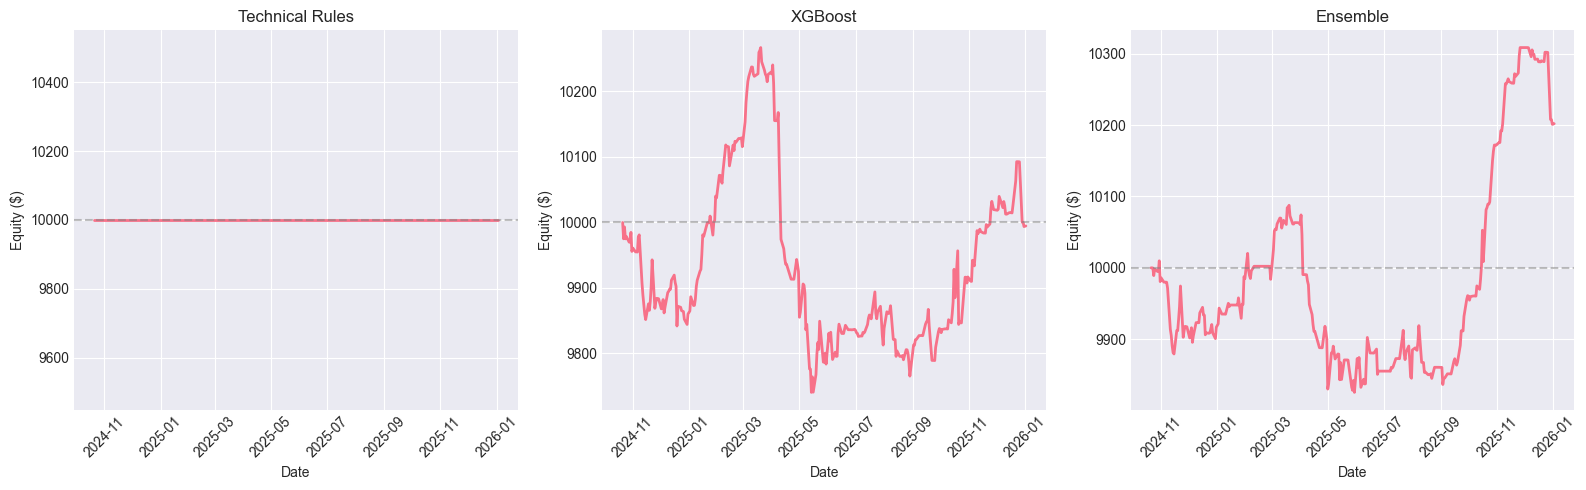

In [18]:
# Plot equity curves
from src.backtesting.visualizations import plot_equity_curve

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

results_list = [
    ('Technical Rules', tech_results),
    ('XGBoost', xgb_results),
    ('Ensemble', ens_results)
]

for ax, (name, results) in zip(axes, results_list):
    if not results['equity_df'].empty:
        equity = results['equity_df']
        ax.plot(equity['date'], equity['equity'], linewidth=2)
        ax.axhline(y=10000, color='gray', linestyle='--', alpha=0.5)
        ax.set_title(f'{name}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Equity ($)')
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{name}')

plt.tight_layout()
plt.show()

## 7. Save Models

In [19]:
# Save models
models_dir = project_root / 'models'
models_dir.mkdir(exist_ok=True)

# Save XGBoost models
for ticker in xgb_model.models.keys():
    xgb_model.save_model(ticker)

# Save ensemble
ensemble.save(str(models_dir / 'ensemble'))

print("Models saved to models/ directory")

Models saved to models/ directory


In [20]:
# Save comparison results
results_dir = project_root / 'results'
results_dir.mkdir(exist_ok=True)

comparison_df.to_csv(results_dir / 'model_comparison.csv', index=False)
print(f"Comparison saved to {results_dir / 'model_comparison.csv'}")

Comparison saved to C:\Users\Abdulfatai Sanusi\Desktop\FOREX MODEL\forex_signal_model\results\model_comparison.csv


## Summary

Phase 2 complete! We trained and evaluated:
- Technical Rules: Rule-based system with 7 conditions
- XGBoost: ML classifier with feature selection
- Ensemble: Weighted combination (40% rules, 60% ML)

**Next Steps (Phase 3):**
- Walk-forward validation
- Hyperparameter optimization
- Production deployment